##**A MDP for Socio-Economic Systems Impacted by Climate Change**



We will discuss the paper by 

Shuvo, Salman Sadiq, et al. "A markov decision process model for socio-economic systems impacted by climate change." International Conference on Machine Learning. PMLR, 2020.


![Photo by Tomas Anunziata from Pexels](https://drive.google.com/uc?id=15O73hRIgklBcx7Q5IS-OyM9lpmhOQ2jy) (Photo by Tomas Anunziata - Pexels)

Short summary of the model:

*   State is two-dimensional (infrastructure $s$, sea level $l$)

*   Infrastructure $s$ is a discrete and sea level $l$ a continuous state variable

* Action $x$ is the development of the infrastructure

* Reward is modelled as cost due to damages from sea level rise and due the action (i.e. investments into the infrastructure)


![](https://drive.google.com/uc?id=1y4P8smsW-fxkpFZ7RjxFJuC5OMnwZHM-)


---

**State transition**

* Action $x$ increases the infrastructure: $s_n = s_{n-1} + x_n$

* The sea level rise $r$ is modelled using a gamma distribution $r \sim \text{Gamma}(\mu, \phi)$ with scale parameter $\phi = 0.5$ and shape paramter $\mu$

* The state transition for the sea level is then just $l_n = l_{n-1} + r_n$

* The initial state is $S_0 = (s_0 = 50, l_0 = 100)$

---

**Sea level rise**

* The authors model three different scenarios (Intermediate low, intermediate and high sea level rise)

* Int. low: $\mu$ increases from 11.2 to 12.388 with 0.012 increments
* Intermediate: $\mu$ increases from 13.0 to 34.78 with 0.22 increments
* High: $\mu$ increases from 14.6 to 87.86 with 0.74 increments

---

**Nature model**

* The cost from nature $z$ depends on the current sea level $l$ and infrastructure $s$

* A generalized Pareto distribution is used to simulate the cost $z_n \sim \text{GeneralizedPareto}(k, \sigma_n, \theta)$ with location parameter $k = -0.001$, scale parameter $\sigma_n$ and shape paramter $\theta = 1$.

* The scale paramter $\sigma_n$ is modelled as:
\begin{equation*}
\sigma_n = \frac{\eta (l_{n-1})^a}{(s_{n-1})^b}
\end{equation*}
with $\eta = 25$, $a=0.9$ and $b=1.1$

---

**Residents model**

* Government request a contribution from residents to the sea level rise investments

* Residents make a binary decision $y_n = \{0, 1\}$ whether to support the government

* The decision is modelled using a score function $h_n$ that gives the probability of support
\begin{equation*}
h_n = \sum_{m=1}^{n-1} \alpha_r^{n-m}x_m z_m
\end{equation*}
with the cooperation index of the residents $\alpha_r = 0.9$
 
* The probability to support the government $p_n$ is given by
\begin{equation*}
p_n = \frac{1}{1+e^{-(h_n - h_0)}}
\end{equation*}
with $h_0 = 5$

---

**Government model**

* Government is the agent who decides how much to invest in the infrastructure

* Government wants to minizime the total discounted cost
\begin{equation*}
C_N = \sum_{n=0}^N \alpha_g^n [ \alpha x_n - \beta y_n + z_n]
\end{equation*}
with discount factor $N=100$, $\alpha_g = 0.9$, $\alpha = 25$ and $\beta = 14$

Import the necessary libraries and implement the cake eating environment.

In [77]:
import gym
from gym import spaces

import numpy as np
from numpy.random import default_rng
import random
from scipy.stats import genpareto

from collections import namedtuple

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

import torch
import torch.nn as nn
import torch.optim as optim

## **0. Environment**

The basic structure of the Gym interface of an environment is shown here: (https://stable-baselines.readthedocs.io/en/master/guide/custom_env.html)



In [78]:
class ShuvoEnv(gym.Env):
    """Custom Environment that follows gym interface"""
    metadata = {'render.modes': ['human']}

    def __init__(self, scenario=2):
        super(ShuvoEnv, self).__init__()

        # Set scenario (i.e. low, intermediate, high sea level rise)
        self.scenario = scenario

        ########## SEA LEVEL RISE ##########
        # Calculate shape parameter mu of gamma distribution for every
        # scenario and time step to simulate sea level rise
        self.mu = np.zeros((3,100))
        self.mu[0,:] = np.arange(11.2,12.388,0.012)
        self.mu[1,:] = np.arange(13,35,0.22)
        self.mu[2,:] = np.arange(14.6,88.6,0.74)

        # Scale parameter of gamma distribution to simulate sea level rise
        self.phi = 0.5


        ########## NATURE MODEL ##########
        # Define parameters of the generalized Pareto distribution to model cost
        # of nature
        self.k = -0.001
        self.theta = 1
        self.eta = 25
        self.a = 0.9
        self.b = 1.1
        
        
        ########## RESIDENTS MODEL ##########
        # Residents' cooperation index
        self.a_r = 0.9

        # Score threshold (i.e.) if the score is h0, then the probability to 
        # support the government is 50%
        self.h0 = 5
        
        
        ########## GOVERNMENT MODEL ##########
        # Cost of action
        self.alpha = 25

        # Residents' contribution
        self.beta = 14




        ########## DEFINE ACTION AND STATE SPACE ##########
        n_actions = 4
        self.action_space = spaces.Discrete(n_actions)

        # Initial sea level and infrastructure
        self.l0 = 100
        self.s0 = 50

        # Maximum sea levels according to their scenarios
        sea_levels = [700, 1300, 2700]
        self.sea_level_max = sea_levels[self.scenario]

        self.infrastructure_max = 100 * (n_actions - 1) + self.s0

        self.observation_space = spaces.Tuple((spaces.Discrete(self.infrastructure_max),
                                               spaces.Box(0, self.sea_level_max, shape=(1,))))

        self.rng = default_rng()
        self.state = None
        self.time_step = None

        
    def step(self, action):
        """
        State transition of the model.

        """
        assert self.action_space.contains(action), "%r (%s) invalid" % (action, type(action))


        # Get the two state variables
        infrastructure, sea_level = self.state

        # Calculate nature's cost
        z = self.nature(infrastructure, sea_level)

        # Determine decision of residents
        y = self.residents(action, z)

        # Calculate overall cost, i.e. the negative reward
        cost = self.alpha * action - self.beta * y + z

        # Calculate the sea level rise
        rise = self.sea_level_rise()

        # State transition
        self.state = np.array([infrastructure + action, sea_level + rise])

        # Increase time step
        self.time_step += 1

        # This is a continuing task
        done = False

        # Include variables in info dict to analyse them
        info = {'Cost': cost,
                'Nature cost': z}
        

        return self.state, cost, done, info


    def sea_level_rise(self):
        """Calculates the sea level rise in the current period.

        Returns:
            rise (float): Rise of sea level.
        """

        rise = self.rng.gamma(self.mu[self.scenario, self.time_step], self.phi)
        return rise

    
    def nature(self, infrastructure, sea_level):
        """Calculates nature's cost due to sea level rise.

        The scale parameter sigma of the generalized Pareto distribution 
        depends on the current state.

        Args:
            infrastructure (int): State variable 1.
            sea_level (float): State variable 2.

        Returns:
            z (float): Cost of nature.
        
        """
        # Calculate scale parameter of generalized Pareto distribution
        sigma = self.eta * sea_level**self.a / infrastructure**self.b

        # Calculate cost
        z = genpareto.rvs(c=self.k, loc=self.theta, scale=sigma)

        return z


    def residents(self, action, z):
        """Implements the residents' model.

        Determines the score and calculates the probability that the residents
        will support the government.

        Args:
            action (int): The action of the government.
            z (float): Cost of nature.

        Returns:
            y (int): 1 if the residents support the government, else 0
        
        """

        # Probability to support government
        p = 1/(1+np.exp(-(self.h-self.h0)))

        # Decision outcome
        y = self.rng.binomial(1, p)

        # Calculate the next score
        self.h = self.a_r * (self.h + action * z)
        

        return y


    def reset(self):
        """Resets the environment.

        Initializes the state and sets time_step and score h to 0.

        Returns:
            state (int): Initial state.
        
        """
        self.state = np.array([self.s0, self.l0])
        self.time_step = 0
        self.h = 0

        return self.state


    # We will not implement render and close function
    def render(self, mode='human'):
        pass
    def close (self):
        pass

---


### **Test the environment**


---


You can find the basic structure to simulate the environment in
the [Open AI documentation](https://gym.openai.com/docs/).
 


In [79]:
# Create the environment
env = ShuvoEnv()
timesteps = 100

# Reset the environment to get initial state
state = env.reset()

# Create a list to store all states during the simulation
state_path = [state]

# Loop over each time step in the episode
# Use a policy to deforest 10 units each period unless there a less units left
# then deforest everything

for _ in range(timesteps):
    action = 0
    state, reward, done, _ = env.step(action)
    
    state_path.append(state)


---

### **Plot the episode**


---


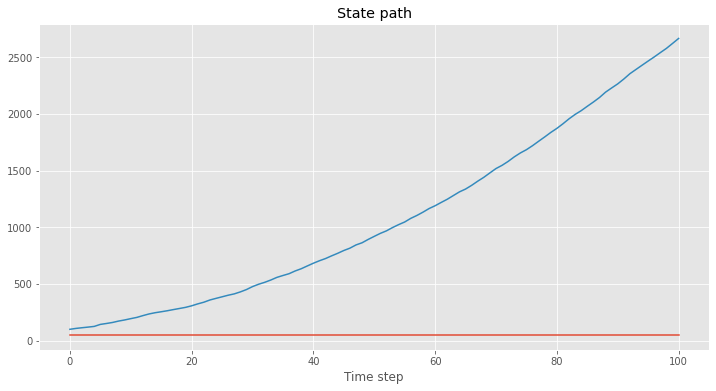

In [80]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_xlabel('Time step')
ax.set_title('State path')

ax.plot(state_path);

## **1. Replay Memory** 

Create Replay Memory

In [ ]:
# Taken from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## **2. Neural Network**

Create a simple fully connected feed-forward network.

In [ ]:
class DeepQNetwork(nn.Module):

    def __init__(self, n_actions):
        super(DeepQNetwork, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, n_actions)
        )

    def forward(self, x):

        return self.model(x)

In [81]:
S = torch.tensor([50., 100.])
S

tensor([ 50., 100.])

In [82]:
network = DeepQNetwork(4)

In [83]:
network(S)

tensor([-0.8184, -8.2439,  1.3073, -2.1129], grad_fn=<AddBackward0>)

In [85]:
S_batch = torch.tensor([[50., 100.], [54., 106.], [60., 156.], [70., 189.]])
S_batch

tensor([[ 50., 100.],
        [ 54., 106.],
        [ 60., 156.],
        [ 70., 189.]])

In [86]:
network(S_batch)

tensor([[ -0.8184,  -8.2439,   1.3073,  -2.1129],
        [ -0.8744,  -8.7707,   1.4011,  -2.2235],
        [ -1.4783, -12.5513,   1.7337,  -3.3682],
        [ -1.8548, -15.1773,   2.0614,  -4.0479]], grad_fn=<AddmmBackward>)

## **3. Deep-Q Network Agent**

**Pseudocode for DQn algorithm**

*Input*: $\alpha_g$, $\alpha_r$, $\alpha$, $\beta$, $\theta$, $k$, $\eta$, $a$, $b$

*Initialize* replay memory $D$ 

*Initialize* main action-value function $Q$ with random weights $\omega$ and target action-value function $Q'$ with weights $\omega ' = \omega$

**for** episode = 1, 2, $\dots$ **do**


> *Initialize* state $S_0 = (s_0, l_0)$

> **for** $n = 1, 2, \dots, 100$ **do**

>> Choose action epsilon-greedily according to $Q(S_n, x, \omega)$

>> Observe cost $c_n$ and next state $S_{n+1}$ and store transition ($S_{n}, x_n, c_n, S_{n+1}$) in $D$

>> Sample random minibatch of transitions ($S_{j}, x_j, c_j, S_{j+1}$) from $D$

>> Set targets $t_j = c_j + \alpha_g \min Q'(S_{j+1}, x, \omega ')$

>> Calculate the loss and perform a gradient descent step with respect to the weights $\omega$

>> Every $d$ steps reset $\omega ' = \omega$

> **end for**

**end for**







In [87]:
class DQNAgent():
    def __init__(self, agent_info):
        """Initialize Agent

        Args: 
            agent_info (dict): parameters used to initialize agent
        """

        # Extract all necessary parameters
        self.n_actions = agent_info["n_actions"]
        self.epsilon = agent_info["epsilon"]
        self.epsilon_min = agent_info["epsilon_min"]
        self.epsilon_decay = agent_info["epsilon_decay"]
        self.discount = agent_info["discount"]


        self.rng = default_rng()

        # Create the main policy net and the target net
        self.policy_net = DeepQNetwork(self.n_actions)
        self.target_net = DeepQNetwork(self.n_actions)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        # Define the loss function
        self.loss_fn = nn.MSELoss()

        # Create an optimizer to perform the weight updates automatically
        self.optimizer = optim.RMSprop(self.policy_net.parameters())

        # Create the replay memory and the batch size that should be sampled from it
        self.memory = ReplayMemory(20000)
        self.batch_size = 1000

        # Keep track of the current step count to update the target net
        self.step_count = 0
        self.target_update = 50

        # Save the current state and action
        self.state = None
        self.action = None


    def step(self, reward, next_state):
        """A step taken by the agent

        Args:
            next_state (tensor):  next state from the environment
        
        Returns:
            next_action (tensor): action the agent takes in next_state
        """
        
        # Update target network after specified number of steps
        self.step_count += 1
        if self.step_count % self.target_update == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
    
        # Save transition in replay memory
        self.memory.push(self.state, self.action, reward, next_state)

        # Choose action using epsilon greedy policy
        next_action = self.select_action(next_state)

        # save current state and action
        self.state = next_state
        self.action = next_action

        # Return action if there are too few transitions in memory
        if len(self.memory) < self.batch_size:
            return next_action

        # Sample a batch of transitions
        transitions = self.memory.sample(self.batch_size)

        # Python Magic: Transform tuple of transitions into transition of tuples
        batch = Transition(*zip(*transitions))

        # We want our data in the shape (n_samples, n_dimesions)
        state_batch = torch.cat(batch.state).view(-1, 2)
        action_batch = torch.cat(batch.action).view(-1, 1)
        reward_batch = torch.cat(batch.reward).view(-1, 1)
        next_state_batch = torch.cat(batch.next_state).view(-1, 2)

        # Calculate action values for the chosen actions
        action_values = self.policy_net(state_batch).gather(dim=1, 
                                                            index=action_batch)
        
        # Calculate the values of all next states 
        next_state_values = self.target_net(next_state_batch).min(dim=1)[0].view(-1, 1).detach()

        # Create target
        target = reward_batch + self.discount * next_state_values
        
        # Calculate loss
        loss = self.loss_fn(action_values, target)

        # Zero the gradients before calculating them
        self.optimizer.zero_grad()
        loss.backward()
        
        # Update the weights
        self.optimizer.step()

        return next_action

        
    def select_action(self, state):
        """Select action using epsilon greedy policy.

        Args:
            state (tensor): Current state.

        Returns:
            action (tensor): Action the agent takes.
        """

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        if self.rng.random() < self.epsilon:
            return torch.tensor(self.rng.integers(self.n_actions)).view(1, 1)
        else:
            return self.policy_net(state).min(dim=-1)[1].view(1, 1).detach()



    def start(self, state):
        """Selects action in inital state.

        Args:
            state (tensor): Initial state.
        
        Returns:
            action (tensor): Initial action.
        """

        action = self.select_action(state)

        self.state = state
        self.action = action

        return action


In [88]:
env = ShuvoEnv()

n_actions = env.action_space.n
epsilon = 0.9
epsilon_min = 0.01
epsilon_decay = 0.99999
discount = 0.9


agent_info = {"n_actions": n_actions,
              "epsilon": epsilon,
              "epsilon_min": epsilon_min,
              "epsilon_decay": epsilon_decay,
              "discount": discount}


agent = DQNAgent(agent_info)


In [ ]:
n_episodes = 200
timesteps = 100

for _ in range(n_episodes):
    state = env.reset()
    state = torch.tensor([state], dtype=torch.float32)
    action = agent.start(state)

    for t in range(timesteps):
        state, reward, done, _ = env.step(action.item())
        state = torch.tensor([state], dtype=torch.float32)
        reward = torch.tensor([reward], dtype=torch.float32)
        action = agent.step(reward, state)